In [1]:
# pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git
from amarinml import *

In [2]:
import numpy as np
import pandas as pd
import copy
import os
import joblib
import ctypes
import gc
from probatus.feature_elimination import ShapRFECV
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from catboost import CatBoostRegressor, Pool
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import shap
from probatus.utils import Scorer
from sklearn.metrics import mean_squared_error, make_scorer, mean_pinball_loss, mean_absolute_error, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

os.environ.pop("OPENBLAS_NUM_THREADS", None)  # None = ignore if not present
SEED = 23
pd.set_option('display.max_columns', None)

In [3]:
# tell Windows to stay awake
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000 | 0x00000001)

-2147483648

In [4]:
class SinglePointTimeSeriesSplitByTicker:
    """
    Time series cross-validator that yields single point test sets by ticker.
    Compatible with scikit-learn's cross_val_score and BayesSearchCV.

    Parameters
    ----------
    n_splits : int, default=3
        Number of splits. Must be at least 1.
    """

    def __init__(self, n_splits=3):
        if n_splits < 1:
            raise ValueError(f"n_splits must be >= 1, got {n_splits}")
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test sets."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError(
                "X must be a pandas DataFrame with 'Ticker' column")

        if 'Ticker' not in X.columns:
            raise ValueError("DataFrame must have a 'Ticker' column")

        # Group by ticker once
        grouped = dict(tuple(X.groupby('Ticker', observed=False)))
        indices = np.arange(len(X))

        for i in range(self.n_splits):
            train_indices = []
            test_indices = []

            for ticker, ticker_df in grouped.items():
                ticker_indices = indices[X['Ticker'] == ticker]
                split_idx = len(ticker_indices) - (i + 1)

                if split_idx > 0:  # Ensure we have enough data
                    train_indices.extend(ticker_indices[:split_idx])
                    test_indices.extend(
                        ticker_indices[split_idx:split_idx + 1])

            if test_indices:  # Only yield if we have test data
                gc.collect()
                yield np.array(train_indices), np.array(test_indices)

    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations."""
        return self.n_splits

In [5]:
# Define RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
df = pd.read_csv('D:\GitHub\sp500\sp500_diff.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by=['Ticker', 'Date'], inplace=True)
df.drop(['Quarter_pct_diff_1', 'Quarter_pct_diff_4',
        'Fiscal year_pct_diff_1', 'Fiscal year_pct_diff_4', 'Fiscal year'], axis=1, inplace=True)
df['Quarter'] = df['Quarter'].astype('int64').astype('category')
print(df.shape)

(17464, 1134)


In [47]:
target = 'Future_Price_pct_diff_1'
df[target] = df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(-1)

predict_df = pd.DataFrame()
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    max_date = ticker_df['Date'].max()
    last_row = ticker_df.loc[ticker_df['Date'] == max_date, :].copy()
    predict_df = pd.concat([predict_df, last_row], ignore_index=True)

df.dropna(inplace=True)
features = df.drop(columns=[target,  'Date'], axis=1).columns.tolist()
cat_features = df.drop(columns=[target, 'Date'], axis=1).select_dtypes(
    include=['object', 'category']).columns.tolist()
num_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['int64', 'float64']).columns.tolist()
print(
    f'Length of numerical features: {len(num_features)}, categorical: {len(cat_features)} , all features: {len(features)}')

Length of numerical features: 1129, categorical: 4 , all features: 1133


In [8]:
split_date = '2025-04-01'
train_df = df[df['Date'] < split_date].copy()
test_df = df[df['Date'] >= split_date].copy()
X_train = train_df[features]


y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [ ]:
# Store average CV scores
medae_scores = []

# Try different delta values for Huber robustness
for delta in [0.5, 1.0, 2.0, 3.0]:
    # Define CatBoost with Huber loss
    model = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_seed=SEED,
        loss_function=f'Huber:delta={delta}',
        eval_metric='RMSE',
        verbose=False,
        thread_count=-1,
        devices='0',
        task_type="GPU",
        data_partition='DocParallel',
        max_ctr_complexity=1,
        cat_features=cat_features,
        boosting_type='Plain',
        bootstrap_type="Bernoulli",
        subsample=0.7,
        border_count=128,
        early_stopping_rounds=50,
        allow_writing_files=False,
        grow_policy="SymmetricTree",
        gpu_ram_part=0.95,
    )

    # Time-series cross-validation
    tscv = SinglePointTimeSeriesSplitByTicker(n_splits=4)

    # Define Median Absolute Error scorer
    medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

    # Cross-validation with MedAE
    scores = cross_val_score(model, X_train, y_train,
                             cv=tscv, scoring=medae_scorer)
    print(f"Delta={delta}, Scores={scores}")
    medae_scores.append(scores.mean())

print("Average Median Absolute Error scores by delta:", medae_scores)

Delta=0.5, Scores=[-0.08256663 -0.09977769 -0.09440348 -0.10860127]
Delta=1.0, Scores=[-0.08232243 -0.10049541 -0.09394007 -0.1089988 ]
Delta=2.0, Scores=[-0.08129779 -0.09862404 -0.09286463 -0.10803188]
Delta=3.0, Scores=[-0.08306537 -0.09993648 -0.09759598 -0.11110009]
Average Median Absolute Error scores by delta: [-0.09633726794572403, -0.09643917912378458, -0.09520458671507445, -0.0979244806914058]


In [ ]:
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=SEED,
    loss_function=f'Huber:delta=2.0',
    eval_metric='RMSE',
    verbose=False,
    thread_count=-1,
    devices='0',
    task_type="GPU",
    data_partition='DocParallel',
    max_ctr_complexity=1,
    cat_features=cat_features,
    boosting_type='Plain',
    bootstrap_type="Bernoulli",
    subsample=0.7,
    border_count=128,
    early_stopping_rounds=50,
    allow_writing_files=False,
    grow_policy="SymmetricTree",
    gpu_ram_part=0.9,
)

In [11]:
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)

# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                                          feature  importance
178                                     MACD_Hist    6.443394
182                         Market Capitalization    3.960569
956                             RSI_14_pct_diff_4    3.867138
287                                       Quarter    3.528663
763                          MinVolume_pct_diff_1    3.164430
762                           MinPrice_pct_diff_4    2.877173
761                           MinPrice_pct_diff_1    2.649828
764                          MinVolume_pct_diff_4    2.410472
758                       MedianVolume_pct_diff_4    2.194707
588  Foreign Exchange Rate Adjustments_pct_diff_4    2.053788
549                      EV/EBIT Ratio_pct_diff_1    1.934332
191                                      MinPrice    1.816002
430                 Cash & Equivalents_pct_diff_4    1.609388
432      Cash & Short-Term Investments_pct_diff_4    1.569818
718                   Long-Term Leases_pct_diff_4    1.452356
757     

c:\Users\Dell\venv\Lib\site-packages\probatus\utils\arrayfuncs.py:108: UserWarning: The following variables in X contains categorical variables: ['Ticker', 'Quarter', 'GICS Sector', 'GICS Sub-Industry']. Make sure to use a model that handles them automatically or encode them into numerical variables.
  warnings.warn(
c:\Users\Dell\venv\Lib\site-packages\probatus\utils\arrayfuncs.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[object_columns] = X[object_columns].astype("category")


Selected: ['Ticker', 'AFFO Per Share', 'Accounts Payable', 'Accounts Receivable', 'Accrued Expenses', 'Accrued Interest Payable', 'Accrued Interest Receivable', 'Acquisition of Real Estate Assets', 'Additional Paid-In Capital', 'Adjusted Funds From Operations (AFFO)', 'Advertising Expenses', 'Allowance for Borrowed Funds for Construction', 'Allowance for Equity Funds for Construction', 'Allowance for Loan Losses', 'Amortization of Goodwill & Intangibles', 'Asset Management Fee', 'Asset Turnover', 'Asset Writedown', 'Asset Writedown & Restructuring Costs', 'Basic Shares Outstanding', 'Book Value Per Share', 'Brokerage Commission', 'Buildings', 'Buyback Yield / Dilution', 'Capital Expenditures', 'Cash & Equivalents', 'Cash & Short-Term Investments', 'Cash Acquisition', 'Cash Acquisitions', 'Cash Growth', 'Cash Income Tax Paid', 'Cash Interest Paid', 'Change in Accounts Payable', 'Change in Accounts Receivable', 'Change in Deferred Taxes', 'Change in Income Taxes', 'Change in Insurance Re

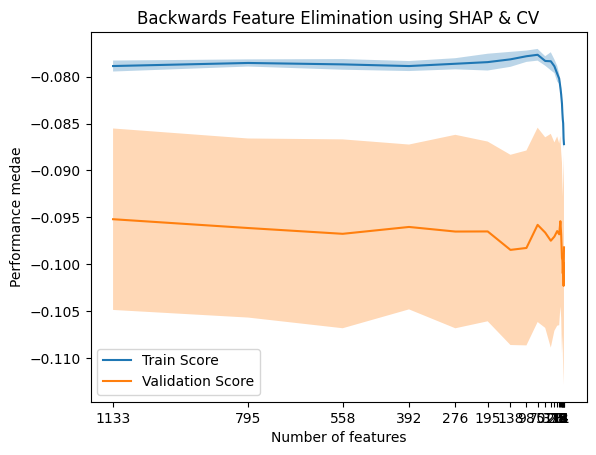

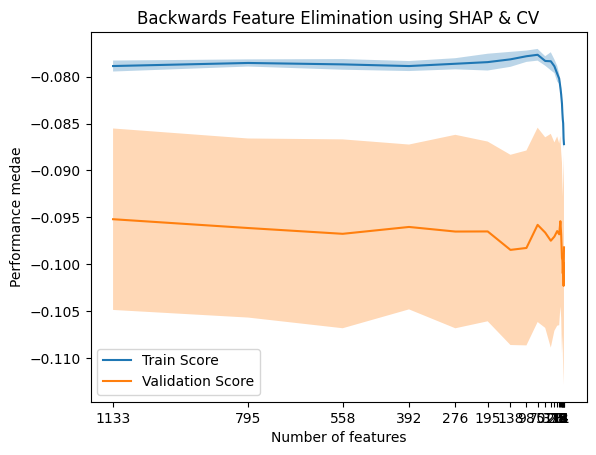

In [12]:
# wrap the sklearn scorer in a probatus Scorer (ShapRFECV requires probatus.utils.Scorer)
probatus_medae = Scorer("medae", custom_scorer=medae_scorer)

shap_selector = ShapRFECV(
    model=model,
    cv=tscv,
    step=0.3,
    scoring=probatus_medae,
    n_jobs=1,
    verbose=1,
    random_state=SEED)

shap_selector.fit(X_train, y_train, columns_to_keep=cat_features)
selected = shap_selector.get_reduced_features_set('best')
print("Selected:", selected)
shap_selector.plot()

In [28]:
n_iter = 30

# Define search space
param_space = {
    'learning_rate': Real(0.02, 0.2, prior='log-uniform'),
    'depth': Integer(4, 8),
    'l2_leaf_reg': Real(1e-3, 5.0, prior='log-uniform'),
    'iterations': Integer(500, 3000),
    'random_strength': Real(1e-3, 2.0, prior='log-uniform'),
    'min_data_in_leaf': Integer(10, 200),
    'leaf_estimation_iterations': Integer(1, 8),
    'subsample': Real(0.6, 0.9),
}


# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=tscv,
    scoring=medae_scorer,
    n_jobs=1,
    n_points=1,
    random_state=SEED,
)

# Fit gs
opt.fit(X_train[selected], y_train, cat_features=cat_features,
        callback=callback, verbose=False)

# Retrieve the best model and results
best_model = opt.best_estimator_
results = opt.cv_results_
params = results['params']

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)

joblib.dump(best_model, 'sp500_best_catboost_model.pkl')

100%|██████████| 30/30 [1:20:05<00:00, 145.34s/it]

Best score: -0.09518815110404223
Best params: OrderedDict([('depth', 6), ('iterations', 500), ('l2_leaf_reg', 0.08109491286974324), ('leaf_estimation_iterations', 5), ('learning_rate', 0.020000000000000004), ('min_data_in_leaf', 27), ('random_strength', 0.001), ('subsample', 0.8870753731742211)])


['sp500_best_catboost_model.pkl']

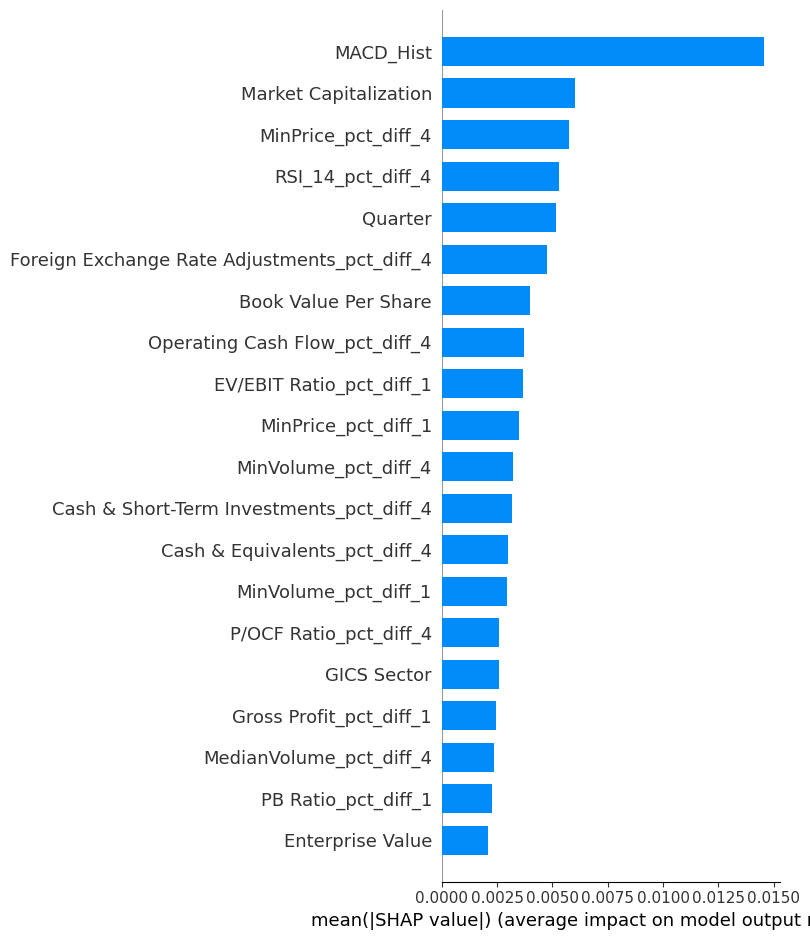

In [30]:
# Use the best model and the selected features
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train[selected])


shap.summary_plot(shap_values, X_train[selected], plot_type="bar")

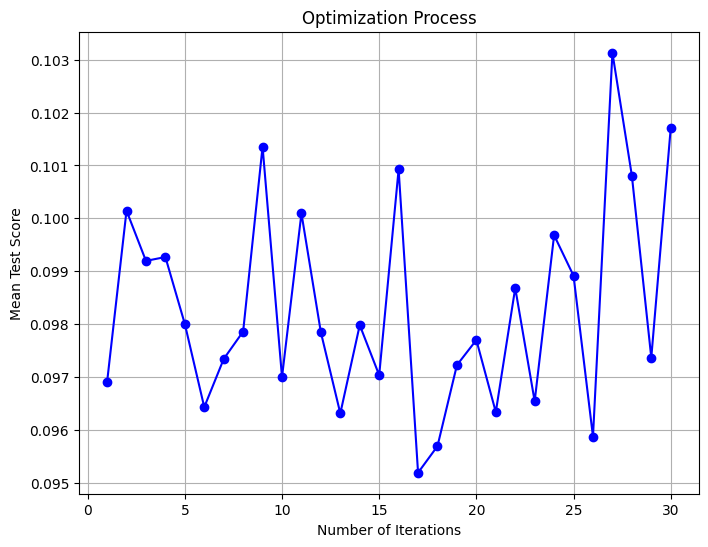

In [31]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'],
         marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

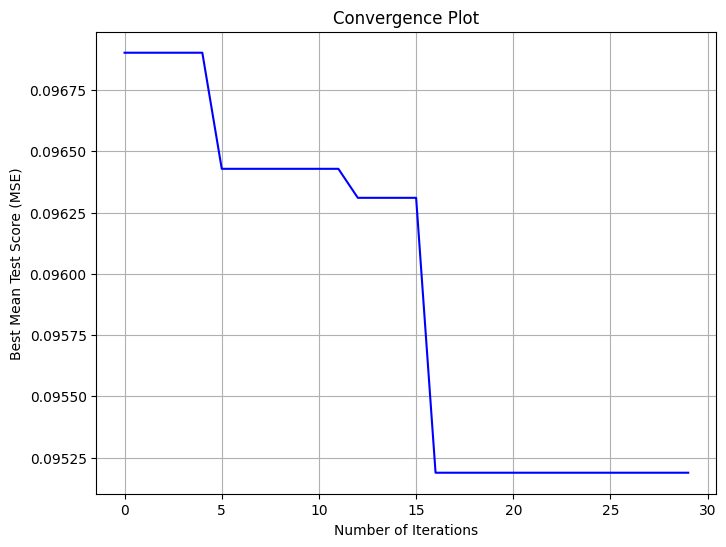

In [32]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

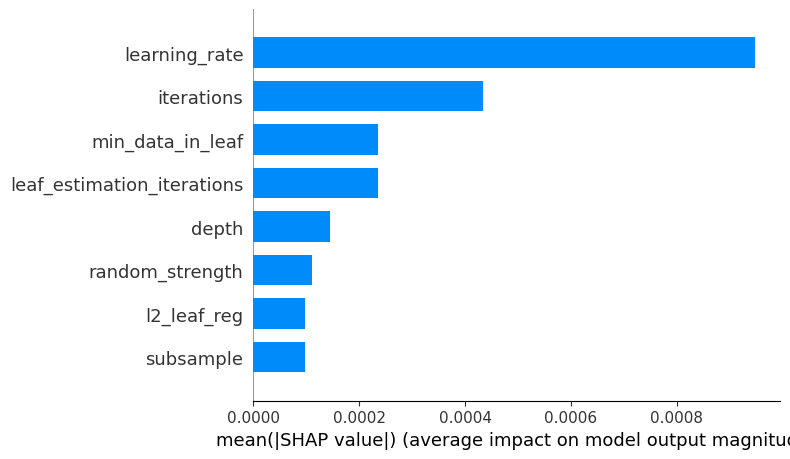

In [33]:

# Mean test scores are negative due to the scoring used
mean_test_scores = -results['mean_test_score']

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# If any hyperparameters are strings (e.g. loss_function), encode them
for col in hyperparams_df.drop('mean_test_score', axis=1).select_dtypes(include='object').columns:
    hyperparams_df[col] = hyperparams_df[col].astype('category').cat.codes

# Rebuild a fresh CatBoostRegressor with the best hyperparameters from search
best_params = opt.best_params_

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = CatBoostRegressor(**best_params, verbose=0)

hyperparam_model.fit(
    hyperparams_df.drop('mean_test_score', axis=1),
    hyperparams_df['mean_test_score']
)

hyperparam_model.fit(hyperparams_df.drop(
    'mean_test_score', axis=1), hyperparams_df['mean_test_score'])


# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop(
    'mean_test_score', axis=1), plot_type="bar")

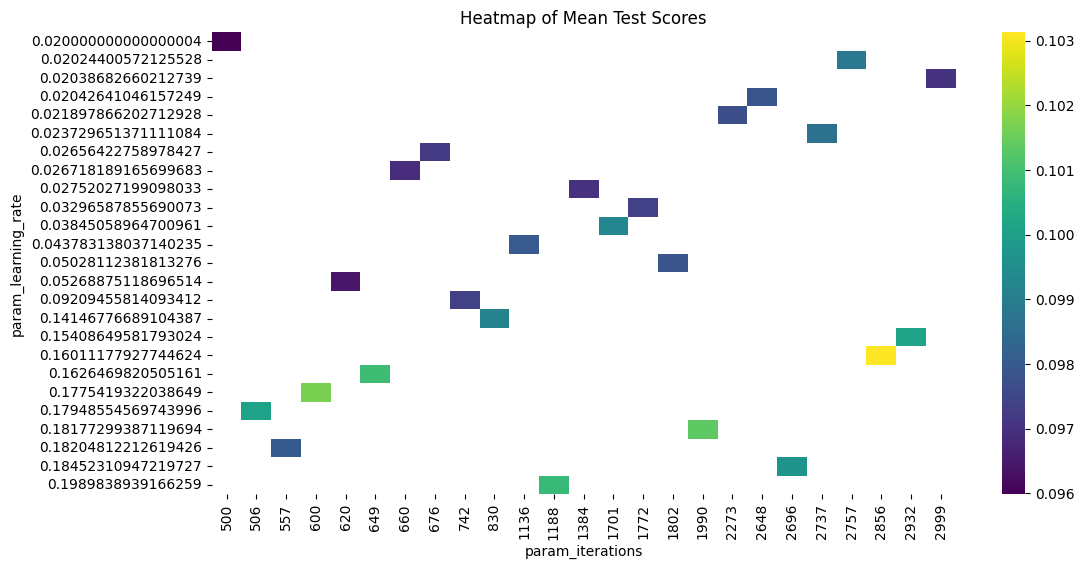

In [34]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [35]:
best_model = joblib.load('sp500_best_catboost_model.pkl')

In [36]:
# Predict on the test set using the best model
preds = best_model.predict(X_test[selected])
errors = np.abs(test_df[target] - preds)

# Create a DataFrame to store actual, predicted, and errors
error_df = test_df[['Ticker', 'Date', target]].copy()
error_df['Predicted'] = preds
error_df['Absolute Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Absolute Error', ascending=False).head(30)

print('Median absolute error:', np.median(errors))
print(top_30_errors)

Median absolute error: 0.08352217921720155
      Ticker        Date  Future_Price_pct_diff_1  Predicted  Absolute Error
11991   NVDA  2025-04-27                 0.563031   0.011178        0.551853
12295     ON  2025-04-04                 0.679525   0.220144        0.459381
4522    DELL  2025-05-02                 0.351522   0.034964        0.316558
15998   ULTA  2025-05-03                 0.282762  -0.033011        0.315773
15473   TRMB  2025-04-04                 0.395859   0.105164        0.290695
11955    NUE  2025-04-05                 0.341304   0.071075        0.270228
877     AMAT  2025-04-27                 0.228756   0.015994        0.212762
9562    LDOS  2025-04-04                 0.239316   0.029769        0.209547
17066    WSM  2025-05-04                 0.173397  -0.034421        0.207818
8382    INTU  2025-04-30                 0.252956   0.056441        0.196515
4558      DG  2025-05-02                 0.208011   0.059225        0.148786
3961    CSCO  2025-04-26         

In [ ]:
# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Predicted', ascending=False).head(30)

top_30_errors

,Ticker,Date,Future_Price_pct_diff_1,Predicted,Absolute Error
12295,ON,2025-04-04,0.679525,0.220144,0.459381
16279,VLTO,2025-04-04,0.169366,0.117413,0.051952
15473,TRMB,2025-04-04,0.395859,0.105164,0.290695
3961,CSCO,2025-04-26,0.218534,0.087534,0.131001
9161,KEYS,2025-04-30,0.127304,0.086604,0.040700
11883,NTAP,2025-04-25,0.192194,0.080263,0.111932
4454,DE,2025-04-27,0.130019,0.078108,0.051912
11955,NUE,2025-04-05,0.341304,0.071075,0.270228
301,ADI,2025-05-03,0.121504,0.068661,0.052843
4558,DG,2025-05-02,0.208011,0.059225,0.148786


In [38]:
preds_binary = [1 if i > 0 else 0 for i in preds]
test_binary = [1 if i > 0 else 0 for i in test_df[target]]

In [39]:
print(confusion_matrix(test_binary, preds_binary))
print(classification_report(test_binary, preds_binary))

[[ 3  6]
 [ 4 22]]
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.79      0.85      0.81        26

    accuracy                           0.71        35
   macro avg       0.61      0.59      0.59        35
weighted avg       0.69      0.71      0.70        35



In [ ]:
preds = best_model.predict(predict_df[selected])
predict_next = pd.DataFrame([predict_df['Ticker'].unique(), preds*100]).T.rename(
    columns={0: 'Ticker', 1: 'Predicted price change pct'})
predict_next.sort_values(by='Predicted price change pct',
                         ascending=False).head(30)

,Ticker,Predicted price change pct
119,CVS,13.87056
371,PLTR,13.313804
238,INTC,11.858488
28,AMGN,11.796649
452,UBER,11.189006
330,NEM,10.866089
213,HAS,10.846588
306,MKTX,10.548985
217,HES,10.394087
475,WBA,10.164485


In [46]:
# restore normal sleep behavior
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)

-2147483648